In [1]:
import numpy as np
import pandas as pd
from zipfile import ZipFile
import os
import rasterio
from scipy import stats

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import BoundaryNorm
from cartopy.feature import NaturalEarthFeature
import cartopy.crs as ccrs
import cartopy

In [29]:
# stage_slope = np.load('./var/stage_slope.npy')
# np.min(stage_slope.shape)
# DamDateStage = np.load('./var/DamDateStage.npy')
# DamDateStage[:, 0, 100, 100]
# TminDamStage = np.load('./var/TminDamStage.npy')
# np.nanargmin(TminDamStage, axis=(2,3))

In [2]:
lat = np.array([49.9166666666664 - i * 0.0416666666667 for i in range(357)])
lon = np.array([-105.0416666666507 + i * 0.0416666666667 for i in range(722)])
Lon, Lat = np.meshgrid(lon, lat)

am = rasterio.open('PRISM_tmin_stable_4kmD2_19810101_bil.bil')
a = am.read()[0, :357, 479:1201]
mask = np.where(a>-1000, 1, 0)

tmin81 = np.load('./prism/mw_tmin/1981_tmin.npz')['tmin']
t, y, x = tmin81.shape
y, x
# np.max(lat), np.min(lat), np.max(lon), np.min(lon)

(357, 722)

<font size=4 color=blue>Clip points in Mid-western US

In [25]:
import geopandas as gpd
from shapely.geometry import Point, Polygon
import pandas as pd

usa = gpd.read_file('./states_21basic/states.shp')
mi_poly = usa[usa.STATE_ABBR == 'MI'].geometry
nd_poly = usa[usa.STATE_ABBR == 'ND'].geometry
sd_poly = usa[usa.STATE_ABBR == 'SD'].geometry
ne_poly = usa[usa.STATE_ABBR == 'NE'].geometry
ks_poly = usa[usa.STATE_ABBR == 'KS'].geometry
ok_poly = usa[usa.STATE_ABBR == 'OK'].geometry
mn_poly = usa[usa.STATE_ABBR == 'MN'].geometry
ia_poly = usa[usa.STATE_ABBR == 'IA'].geometry
mo_poly = usa[usa.STATE_ABBR == 'MO'].geometry
wi_poly = usa[usa.STATE_ABBR == 'WI'].geometry
il_poly = usa[usa.STATE_ABBR == 'IL'].geometry
in_poly = usa[usa.STATE_ABBR == 'IN'].geometry
oh_poly = usa[usa.STATE_ABBR == 'OH'].geometry
ky_poly = usa[usa.STATE_ABBR == 'KY'].geometry
wv_poly = usa[usa.STATE_ABBR == 'WV'].geometry
pa_poly = usa[usa.STATE_ABBR == 'PA'].geometry

poly = [mi_poly, nd_poly, sd_poly, ne_poly, ks_poly, ok_poly, mn_poly, ia_poly, mo_poly, wi_poly, il_poly, in_poly, oh_poly, 
        ky_poly, wv_poly, pa_poly]
mdmask = [np.zeros((y, x)) for k in range(16)]
for i in range(y):
    for j in range(x):
        if mask[i, j]:
            p = Point(Lon[i, j], Lat[i, j])
            for k in range(16):
                mdmask[k][i, j] = np.array(poly[k].contains(p))
states = ['MI', 'ND', 'SD', 'NE', 'KS', 'OK', 'MN', 'IA', 'MO', 'WI', 'IL', 'IN', 'OH', 'KY', 'WV', 'PA']
[np.save(f'./var/{states[ii]}_mask', mdmask[ii]) for ii in range(16)]

In [10]:
import geopandas as gpd
from shapely.geometry import Point, Polygon
import pandas as pd

usa = gpd.read_file('./states_21basic/states.shp')
ar_poly = usa[usa.STATE_ABBR == 'AR'].geometry
tn_poly = usa[usa.STATE_ABBR == 'TN'].geometry
md_poly = usa[usa.STATE_ABBR == 'MD'].geometry
ny_poly = usa[usa.STATE_ABBR == 'NY'].geometry
va_poly = usa[usa.STATE_ABBR == 'VA'].geometry
nc_poly = usa[usa.STATE_ABBR == 'NC'].geometry

poly = [ar_poly, tn_poly, md_poly, ny_poly, va_poly, nc_poly]
mdmask = [np.zeros((y, x)) for k in range(6)]
for i in range(y):
    for j in range(x):
        if mask[i, j]:
            p = Point(Lon[i, j], Lat[i, j])
            for k in range(6):
                mdmask[k][i, j] = np.array(poly[k].contains(p))
states = ['AR', 'TN', 'MD', 'NY', 'VA', 'NC']
for ii in range(6):
    np.save(f'./var/{states[ii]}_mask', mdmask[ii])

In [4]:
for yl in range(38):
    DIR = f'./prism/data/tmax/{1981+yl}/'
    fna = [name for name in os.listdir(DIR)]
    fna.sort()
    fno = len(fna)
    for i in range(fno):
        z = ZipFile(DIR+fna[i])
        z.extractall(DIR+fna[i][:-4])

In [4]:
for yl in range(38):
    tmax = []
    folder = f'./prism/data/tmax/{1981+yl}/'
    subfolders = [ f.path for f in os.scandir(folder) if f.is_dir() ]
    for i in range(len(subfolders)):
        bil = rasterio.open(subfolders[i]+'/'+subfolders[i][23:]+'.bil')
        a = bil.read()[0, :357, 479:1201]
        tmax.append(a)
    tmax = np.array(tmax)
    np.savez_compressed(f'./prism/mw_tmax/{1981+yl}_tmax', tmax=tmax)

In [3]:
from os.path import isfile, join
for yl in range(38,39):
    DIR = f'./prism/data/tmin/{1981+yl}/'
    fna = [name for name in os.listdir(DIR) if isfile(join(DIR, name))]
    fna.sort()
    fno = len(fna)
    for i in range(fno):
        z = ZipFile(DIR+fna[i])
        z.extractall(DIR+fna[i][:-4])

In [4]:
for yl in range(38,39):
    tmin = []
    folder = f'./prism/data/tmin/{1981+yl}/'
    subfolders = [ f.path for f in os.scandir(folder) if f.is_dir() ]
    for i in range(len(subfolders)):
        bil = rasterio.open(subfolders[i]+'/'+subfolders[i][23:]+'.bil')
        a = bil.read()[0, :357, 479:1201]
        tmin.append(a)
    tmin = np.array(tmin)
    np.savez_compressed(f'./prism/mw_tmin/{1981+yl}_tmin', tmin=tmin)

In [5]:
for yl in range(38,39):
    DIR = f'./prism/data/tmean/{1981+yl}/'
    fna = [name for name in os.listdir(DIR)]
    fna.sort()
    fno = len(fna)
    for i in range(fno):
        z = ZipFile(DIR+fna[i])
        z.extractall(DIR+fna[i][:-4])

In [6]:
for yl in range(38,39):
    tmean = []
    folder = f'./prism/data/tmean/{1981+yl}/'
    subfolders = [ f.path for f in os.scandir(folder) if f.is_dir() ]
    for i in range(len(subfolders)):
        bil = rasterio.open(subfolders[i]+'/'+subfolders[i][23:]+'.bil')
        a = bil.read()[0, :357, 479:1201]
        tmean.append(a)
    tmean = np.array(tmean)
    np.savez_compressed(f'./prism/mw_tmean/{1981+yl}_tmean', tmean=tmean)

In [19]:
for yl in range(18):
    DIR = f'./prism/data/prec/{2001+yl}/'
    fna = [name for name in os.listdir(DIR)]
    fna.sort()
    fno = len(fna)
    for i in range(fno):
        z = ZipFile(DIR+fna[i])
        z.extractall(DIR+fna[i][:-4])

In [ ]:
for yl in range(38):
    prec = []
    folder = f'./prism/data/prec/{1981+yl}/'
    subfolders = [ f.path for f in os.scandir(folder) if f.is_dir() ]
    for i in range(len(subfolders)):
        bil = rasterio.open(subfolders[i]+'/'+subfolders[i][23:]+'.bil')
        a = bil.read()[0, :357, 479:1201]
        prec.append(a)
    prec = np.array(prec)
    np.savez_compressed(f'./prism/mw_prec/{1981+yl}_prec', prec=prec)

In [3]:
for yl in range(10):
    DIR = f'./prism/data/vpdmax/{2006+yl}/'
    fna = [name for name in os.listdir(DIR)]
    fna.sort()
    fno = len(fna)
    for i in range(fno):
        z = ZipFile(DIR+fna[i])
        z.extractall(DIR+fna[i][:-4])

In [95]:
dff = pd.date_range(start='1/1/1981', end='12/31/2018', freq='D')
year = np.array(dff.strftime('%Y')).astype(int)
year = np.delete(year, [1154, 2615, 4076, 5537, 6998, 8459, 9920, 11381, 12842])
mon = np.array(dff.strftime('%-m')).astype(int)
mon = np.delete(mon, [1154, 2615, 4076, 5537, 6998, 8459, 9920, 11381, 12842])
day = np.array(dff.strftime('%-d')).astype(int)
day = np.delete(day, [1154, 2615, 4076, 5537, 6998, 8459, 9920, 11381, 12842])

In [124]:
for i in range(y):
    for j in range(x):
        if mask[i, j]:
            tminij = []
            tmaxij = []
            precij = []
            for yl in range(38):
                tmin = np.load(f'./prism/mw_tmin/{1981+yl}_tmin.npz')['tmin']
                tminij.extend(tmin[:, i, j])
                tmax = np.load(f'./prism/mw_tmax/{1981+yl}_tmax.npz')['tmax']
                tmaxij.extend(tmax[:, i, j])
                prec = np.load(f'./prism/mw_prec/{1981+yl}_prec.npz')['prec']
                precij.extend(prec[:, i, j])
            tminij = np.array(tminij)
            tminij = np.delete(tminij, [1154, 2615, 4076, 5537, 6998, 8459, 9920, 11381, 12842])
            tmaxij = np.array(tmaxij)
            tmaxij = np.delete(tmaxij, [1154, 2615, 4076, 5537, 6998, 8459, 9920, 11381, 12842])
            precij = np.array(precij)
            precij = np.delete(precij, [1154, 2615, 4076, 5537, 6998, 8459, 9920, 11381, 12842])


            f = open(f'./prism/GDD_data/{Lat[i, j]:.2f}_{Lon[i, j]:.2f}_1981-2018.txt', "a")
            f.write('YEAR,MONTH,DAY,MAX,MIN,PREC\n')
            for k in range(len(year)):
                f.write(f'{year[k]}, {mon[k]}, {day[k]}, {tmaxij[k]:.1f}, {tminij[k]:.1f}, {precij[k]:.2f}\n')
            f.close()

In [24]:
# DIR = './prism/GDD_data'
# fna = [name for name in os.listdir(DIR)]
# fna.sort()
# fno = len(fna)
# for filename in fna:
#     os.rename(os.path.join(DIR, filename), os.path.join(DIR, filename.replace(" ", "")))

In [18]:
flag = []
for i in range(y):
    for j in range(x):
        if mask[i, j]:
            flag.append(f'{Lat[i, j]:5.2f}_{Lon[i, j]:7.2f}_1981-2018.txt')

In [19]:
# f = open('./GDD/input_list.txt', 'w')
# for ii in range(fno):
#     if fna[ii] in flag:
#         f.write(f'{fna[ii].replace(" ", "")}\n')
# f.close()

In [20]:
f1 = open('./GDD/output_daily_list.txt', 'w')
f2 = open('./GDD/output_yearly_list.txt', 'w')
for ii in range(fno):
    if fna[ii] in flag:
        f1.write(f'{fna[ii].replace(" ", "").replace("1981-2018", "daily")}\n')
        f2.write(f'{fna[ii].replace(" ", "").replace("1981-2018", "yearly")}\n')
f1.close()
f2.close()

In [22]:
gdd = np.zeros((y, x)) * np.nan
for i in range(y):
    for j in range(x):
        if mask[i, j]:
            df = pd.read_table(f'./GDD/output/daily/{Lat[i, j]:.2f}_{Lon[i, j]:.2f}_daily.txt', delim_whitespace=True, 
                                   names=('YR','cd','TMAX','TMIN','gdd','CDHTOT','STAGE','DAM','YLD','INJDAYS'))
            gdd[i,j] = np.array([df.gdd[59+365*i:151+365*i].sum() for i in range(38)]).mean()

np.save('gdd', gdd)

<font size=4 color=blue>First date of Stage 2

In [4]:
fds2 = np.zeros((38, y, x)) * np.nan
for i in range(y):
    for j in range(x):
        if mask[i, j]:
            df = pd.read_table(f'./GDD/output_Cherry/daily/{Lat[i, j]:.2f}_{Lon[i, j]:.2f}_daily.txt', delim_whitespace=True, 
                                   names=('YR','cd','TMAX','TMIN','rprecip','gdd','CDHTOT','STAGE','rgdd','FDIAMT'))
            stage = df.STAGE
            for k in range(38):
                flag = np.where(stage[k*365:(k+1)*365] == 2.0)[0]
                if len(flag):
                    fds2[k, i, j] = min(flag)
                else:
                    fds2[k, i, j] = min(np.where(stage[k*365:(k+1)*365] > 2.0)[0])

np.save('./var/first_date_stage2', fds2)

In [8]:
fds2 = np.load('./var/first_date_stage2.npy')
extent = [-105, -75, 34, 49]
fig = plt.figure(figsize=(8, 6))
ax = plt.axes(projection=ccrs.AlbersEqualArea(np.mean(extent[:2]), np.mean(extent[2:])))
ax.set_extent(extent)
states = NaturalEarthFeature(category="cultural", scale="50m",
                             facecolor="none",
                             name="admin_1_states_provinces_shp")
ax.add_feature(states, linewidth=.3, edgecolor="black")
ax.add_feature(cartopy.feature.BORDERS, lw=.3, linestyle=':')
ax.add_feature(cartopy.feature.COASTLINE, lw=.3, linestyle=':')
ax.add_feature(cartopy.feature.LAKES, edgecolor='black', facecolor='white', lw=.3)

cmap = plt.get_cmap('jet_r')

pc = plt.pcolormesh(Lon, Lat, fds2.mean(axis=0), cmap=cmap, transform=ccrs.PlateCarree())

plt.title('Averaged First Date of Stage 2 from 1981 to 2018', fontsize=15, fontweight='bold')

fig.subplots_adjust(bottom=0, top=0.95, left=0.05, right=0.9)
cb_ax = fig.add_axes([0.905, 0.12, 0.02, 0.72])
cbar = fig.colorbar(pc, cax=cb_ax)
plt.savefig(f'./plot/PRISM/First_Stage2_Date.png')
plt.close()

<font size=4 color=blue>Daily Variables

In [3]:
DamDayann = np.zeros((38, y, x)) * np.nan
DamDayStage = np.zeros((38, 9, y, x)) * np.nan
DamMeanStage = np.zeros((38, 9, y, x)) * np.nan
TminStage = np.zeros((38, 9, y, x)) * np.nan
DamDateStage = np.zeros((38, 9, y, x)) * np.nan
TminDamStage = np.zeros((38, 9, y, x)) * np.nan
stage = [0., 2., 3., 4., 5., 6., 7., 8., 9.]
for i in range(y):
    for j in range(x):
        if mask[i, j]:
            df = pd.read_table(f'./GDD/output_Cherry/daily/{Lat[i, j]:.2f}_{Lon[i, j]:.2f}_daily.txt', delim_whitespace=True, 
                                   names=('YR','cd','TMAX','TMIN','rprecip','gdd','CDHTOT','STAGE','rgdd','FDIAMT','FDIAMS','DAM','YLD'))
            for yl in range(38):
                dfyl = df[yl*365:(yl+1)*365]
                grouped = dfyl.groupby(dfyl['STAGE'])
                if not (len(grouped) - 9):
                    DamDayann[yl, i, j] = np.where(dfyl['DAM'], 1, 0).sum()
                    DamDayStage[yl, :, i, j] = grouped['DAM'].apply(lambda column: (column != 0).sum())
                    DamMeanStage[yl, :, i, j] = grouped['DAM'].mean()
                    TminStage[yl, :, i, j] = grouped['TMIN'].mean()
                    
                    DamDay = grouped['DAM'].apply(lambda column: column.to_numpy().nonzero())
                    for key, item in grouped:
                        damid = DamDay[key][0]
                        if len(damid):
                            index = stage.index(key)
                            DamDateStage[yl, index, i, j] = np.array([item['cd'].iloc[ii] for ii in damid]).mean()
                            TminDamStage[yl, index, i, j] = np.array([item['TMIN'].iloc[ii] for ii in damid]).mean()
#             break
# np.save('./var/DamDateStage', DamDateStage)
# np.save('./var/TminDamStage', TminDamStage)
# np.save('./var/DamDayann', DamDayann)
# np.save('./var/DamDayStage', DamDayStage)
# np.save('./var/DamMeanStage', DamMeanStage)
# np.save('./var/TminStage', TminStage)

In [32]:
DamDayann = np.load('./var/DamDayann.npy')
# DamDayann = DamDayann[np.r_[0:30,32:38]]
DamDayann_mean = np.nanmean(DamDayann, axis=0)
DamDayann_std = np.nanstd(DamDayann, axis=0)
DamDayann_std_mean = DamDayann_std / DamDayann_mean
png = ['DamDayann_mean', 'DamDayann_std', 'DamDayann_std_mean']
title = ['38 year mean', 'Standard Deviation', 'Coefficient of variation']
data = [DamDayann_mean, DamDayann_std, DamDayann_std_mean]
extent = [-105, -75, 34, 49]
ll = [0, 0, 0]
lr = [10, 10, 2]
step = [1, 1, .2]
for ii in range(3):
    fig = plt.figure(figsize=(8, 6))
    ax = plt.axes(projection=ccrs.AlbersEqualArea(np.mean(extent[:2]), np.mean(extent[2:])))
    ax.set_extent(extent)
    ax.add_feature(cartopy.feature.STATES.with_scale('10m'), lw=.5)
    ax.add_feature(cartopy.feature.BORDERS, lw=.3, linestyle=':')
    ax.add_feature(cartopy.feature.COASTLINE, lw=.3, linestyle=':')
    ax.add_feature(cartopy.feature.LAKES, edgecolor='black', facecolor='white', lw=.3)

    levels = MaxNLocator(nbins=100).tick_values(ll[ii], lr[ii])
    cmap = plt.get_cmap('jet')
    norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

    pc = plt.pcolormesh(Lon, Lat, data[ii], cmap=cmap, norm=norm, transform=ccrs.PlateCarree())
    plt.title(f'{title[ii]} of total damage days from 1981 to 2018', fontsize=13, fontweight='bold')
    fig.subplots_adjust(bottom=0, top=0.95, left=0.05, right=0.9)
    cb_ax = fig.add_axes([0.905, 0.12, 0.02, 0.72])
    cbar = fig.colorbar(pc, cax=cb_ax, ticks=np.arange(ll[ii], lr[ii]+step[ii], step[ii]), extend='max')
    plt.savefig(f'./plot/freeze_index/{png[ii]}')
    plt.close()

<ipython-input-32-f7fd65f68d06>:3: RuntimeWarning: Mean of empty slice
  DamDayann_mean = np.nanmean(DamDayann, axis=0)
<ipython-input-32-f7fd65f68d06>:5: RuntimeWarning: invalid value encountered in true_divide
  DamDayann_std_mean = DamDayann_std / DamDayann_mean


### By region

In [3]:
states = ['MI', 'ND', 'SD', 'NE', 'KS', 'OK', 'MN', 'IA', 'MO', 'WI', 'IL', 'IN', 'OH', 'KY', 'WV', 'PA', 'AR', 'TN', 'NY', 'MD', 'VA', 'NC']
mdmask = {states[ii]:np.load(f'./var/{states[ii]}_mask.npy') for ii in range(22)}

NWmask = np.where(np.logical_or.reduce((mdmask['ND'], mdmask['SD'], mdmask['NE'])), 1, 0)
SWmask = np.where(np.logical_or.reduce((mdmask['KS'], mdmask['OK'], mdmask['AR'])), 1, 0)
NCmask = np.where(np.logical_or.reduce((mdmask['MN'], mdmask['IA'], mdmask['WI'], mdmask['MI'])), 1, 0)
Cmask = np.where(np.logical_or.reduce((mdmask['MO'], mdmask['IL'], mdmask['IN'], mdmask['OH'], mdmask['KY'], mdmask['TN'], mdmask['WV'])), 1, 0)
NEmask = np.where(np.logical_or.reduce((mdmask['NY'], mdmask['PA'], mdmask['MD'])), 1, 0)
SEmask = np.where(np.logical_or(mdmask['VA'], mdmask['NC']), 1, 0)

In [18]:
# states = ['MI', 'ND', 'SD', 'NE', 'KS', 'OK', 'MN', 'IA', 'MO', 'WI', 'IL', 'IN', 'OH', 'KY', 'WV', 'PA']
# mdmask = [np.load(f'./var/{states[ii]}_mask.npy') for ii in range(16)]
mdmask = [NWmask, SWmask, NCmask, Cmask, NEmask, SEmask]
region = ['Northern Great Plains', 'Southern Great Plains', 'Upper Midwest', 'Ohio Valley', 'Northeast', 'Southeast']
DamDayann = np.load('./var/DamDayann.npy')
DamDayann_states = np.zeros((38, 6))
for yl in range(38):
    DamDayann_states[yl, :] = np.array([np.nanmean(np.where(mdmask[ii], DamDayann[yl, :, :], np.nan)) for ii in range(6)])

X = np.linspace(1981, 2018, 38)
# X = X[np.r_[0:30,32:38]]
fig, axs = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(10, 7))
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.plot(X, DamDayann_states[:, i], 'bo-', ms=3)
    plt.ylim(0, 25)
    plt.text(1980, 23, f'mean = {np.nanmean(DamDayann_states[:, i]):.2f}', fontsize='large')
    plt.text(1980, 18, f'std = {np.nanstd(DamDayann_states[:, i]):.2f}', fontsize='large')
    plt.title(f'{region[i]}', fontsize='large', fontweight='bold')
    plt.xticks(np.arange(1981, 2018, 4), ['81', '85', '89', '93', '97', '01', '05', '09', '13', '17'])
    plt.grid()
    plt.subplots_adjust(wspace=.06)
#         plt.xticks([], [])
    if i % 3:
        plt.yticks(np.arange(0, 26, 5), [])
    else:
        plt.yticks(np.arange(0, 26, 5))
        
# plt.savefig('./plot/freeze_index/TotDamDays.png')
plt.savefig('./plot/freeze_index/RegionTotDamDays.png', bbox_inches='tight')
plt.close()

In [25]:
DamDayStage = np.load('./var/DamDayStage.npy')
# states = ['MI', 'ND', 'SD', 'NE', 'KS', 'OK', 'MN', 'IA', 'MO', 'WI', 'IL', 'IN', 'OH', 'KY', 'WV', 'PA']
# mdmask = [np.load(f'./var/{states[ii]}_mask.npy') for ii in range(16)]
# DamDayStage = DamDayStage[np.r_[0:30,32:38]]
# DamDayStage_states = np.zeros((36, 9, 16))
DamDayStage_states = np.zeros((38, 9, 6))
for yl in range(38):
    for st in range(9):
        DamDayStage_states[yl, st, :] = np.array([np.nanmean(np.where(mdmask[ii], DamDayStage[yl, st, :, :], np.nan)) for ii in range(6)])
DamDayStage_states_sum = np.nansum(DamDayStage_states, axis=0)

X = np.linspace(0, 8, 9)
fig, axs = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(10, 7))
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.bar(X, DamDayStage_states_sum[:, i])
    plt.ylim(0, 100)
    plt.title(f'{region[i]}', fontsize='large', fontweight='bold')
    plt.xticks(X, ['0', '2', '3', '4', '5', '6', '7', '8', '9'])
    plt.subplots_adjust(wspace=.06)
    if i % 3:
        plt.yticks([], [])
# plt.savefig('./plot/freeze_index/StageTotDamDays_all.png')
plt.savefig('./plot/freeze_index/RegionStageTotDamDays_all.png', bbox_inches='tight')
plt.close()

In [26]:
DamMeanStage = np.load('./var/DamMeanStage.npy')
# states = ['MI', 'ND', 'SD', 'NE', 'KS', 'OK', 'MN', 'IA', 'MO', 'WI', 'IL', 'IN', 'OH', 'KY', 'WV', 'PA']
# mdmask = [np.load(f'./var/{states[ii]}_mask.npy') for ii in range(16)]
# DamMeanStage = DamMeanStage[np.r_[0:30,32:38]]
DamMeanStage_states = np.zeros((38, 9, 6))
for yl in range(38):
    for st in range(9):
        DamMeanStage_states[yl, st, :] = np.array([np.nanmean(np.where(mdmask[ii], DamMeanStage[yl, st, :, :], np.nan)) for ii in range(6)])
DamMeanStage_states_sum = np.nanmean(DamMeanStage_states, axis=0)

X = np.linspace(0, 8, 9)
fig, axs = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(10, 7))
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.bar(X, DamMeanStage_states_sum[:, i])
    plt.ylim(0, 0.1)
    plt.title(f'{region[i]}', fontsize='large', fontweight='bold')
    plt.xticks(X, ['0', '2', '3', '4', '5', '6', '7', '8', '9'])
    plt.subplots_adjust(wspace=.06)
    if i % 3:
        plt.yticks([], [])
plt.savefig('./plot/freeze_index/RegionStagemeanDamvalue_all.png', bbox_inches='tight')

In [29]:
TminStage = np.load('./var/TminStage.npy')
# states = ['MI', 'ND', 'SD', 'NE', 'KS', 'OK', 'MN', 'IA', 'MO', 'WI', 'IL', 'IN', 'OH', 'KY', 'WV', 'PA']
# mdmask = [np.load(f'./var/{states[ii]}_mask.npy') for ii in range(16)]
# TminStage = TminStage[np.r_[0:30,32:38]]
TminStage_states = np.zeros((38, 9, 6))
for yl in range(38):
    for st in range(9):
        TminStage_states[yl, st, :] = np.array([np.nanmean(np.where(mdmask[ii], TminStage[yl, st, :, :], np.nan)) for ii in range(6)])
TminStage_states_sum = np.nanmean(TminStage_states, axis=0)

X = np.linspace(0, 8, 9)
fig, axs = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(10, 7))
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.bar(X, TminStage_states_sum[:, i])
    plt.ylim(-12, 12)
    plt.title(f'{region[i]}', fontsize='large', fontweight='bold')
    plt.xticks(X, ['0', '2', '3', '4', '5', '6', '7', '8', '9'])
    plt.subplots_adjust(wspace=.06)
    if i % 3:
        plt.yticks([], [])
# plt.savefig('./plot/freeze_index/StagemeanTmin_all.png')
plt.savefig('./plot/freeze_index/RegionStagemeanTmin_all.png', bbox_inches='tight')

In [32]:
TminDamStage = np.load('./var/TminDamStage.npy')
# states = ['MI', 'ND', 'SD', 'NE', 'KS', 'OK', 'MN', 'IA', 'MO', 'WI', 'IL', 'IN', 'OH', 'KY', 'WV', 'PA']
# mdmask = [np.load(f'./var/{states[ii]}_mask.npy') for ii in range(16)]
# TminDamStage = TminDamStage[np.r_[0:30,32:38]]
TminDamStage_states = np.zeros((38, 9, 6))
for yl in range(38):
    for st in range(9):
        TminDamStage_states[yl, st, :] = np.array([np.nanmean(np.where(mdmask[ii], TminDamStage[yl, st, :, :], np.nan)) for ii in range(6)])
TminDamStage_states_mean = np.nanmean(TminDamStage_states, axis=0)

X = np.linspace(0, 8, 9)
fig, axs = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(10, 7))
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.plot(X, TminDamStage_states_mean[:, i], 'b-o', ms=3)
    plt.ylim(-10, 0)
    plt.title(f'{region[i]}', fontsize='large', fontweight='bold')
    plt.xticks(X, ['0', '2', '3', '4', '5', '6', '7', '8', '9'])
    plt.grid()
    plt.subplots_adjust(wspace=.06)
    if i % 3:
        plt.yticks(np.arange(-10, 0, 2), [])
    else:
        plt.yticks(np.arange(-10, 0, 2))
# plt.savefig('./plot/freeze_index/StageDammeanTmin_all.png')
plt.savefig('./plot/freeze_index/RegionStageDammeanTmin_all.png', bbox_inches='tight')

<ipython-input-32-5688860c6fb2>:8: RuntimeWarning: Mean of empty slice
  TminDamStage_states[yl, st, :] = np.array([np.nanmean(np.where(mdmask[ii], TminDamStage[yl, st, :, :], np.nan)) for ii in range(6)])


In [34]:
DamDateStage = np.load('./var/DamDateStage.npy')
# states = ['MI', 'ND', 'SD', 'NE', 'KS', 'OK', 'MN', 'IA', 'MO', 'WI', 'IL', 'IN', 'OH', 'KY', 'WV', 'PA']
# mdmask = [np.load(f'./var/{states[ii]}_mask.npy') for ii in range(16)]
# DamDateStage = DamDateStage[np.r_[0:30,32:38]]
DamDateStage_states = np.zeros((38, 9, 6))
for yl in range(38):
    for st in range(9):
        DamDateStage_states[yl, st, :] = np.array([np.nanmean(np.where(mdmask[ii], DamDateStage[yl, st, :, :], np.nan)) for ii in range(6)])
DamDateStage_states_sum = np.nanmean(DamDateStage_states, axis=0)

X = np.linspace(0, 8, 9)
fig, axs = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(10, 7))
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.bar(X, DamDateStage_states_sum[:, i])
    plt.ylim(0, 160)
    plt.title(f'{region[i]}', fontsize='large', fontweight='bold')
    plt.xticks(X, ['0', '2', '3', '4', '5', '6', '7', '8', '9'])
    plt.subplots_adjust(wspace=.06)
    if i % 3:
        plt.yticks([], [])
# plt.savefig('./plot/freeze_index/StageDammeanDate_all.png')
plt.savefig('./plot/freeze_index/RegionStageDammeanDate_all.png', bbox_inches='tight')

<ipython-input-34-5ae5782f74b0>:8: RuntimeWarning: Mean of empty slice
  DamDateStage_states[yl, st, :] = np.array([np.nanmean(np.where(mdmask[ii], DamDateStage[yl, st, :, :], np.nan)) for ii in range(6)])


In [26]:
DamDayStage = np.load('./var/DamDayStage.npy')
DamMeanStage = np.load('./var/DamMeanStage.npy')
TminStage = np.load('./var/TminStage.npy')
DamDateStage = np.load('./var/DamDateStage.npy')
TminDamStage = np.load('./var/TminDamStage.npy')

data = [DamDayStage, DamMeanStage, TminStage, DamDateStage, TminDamStage]
data = [np.nanmean(data[i], axis=0) for i in range(5)]
title = ['38-year mean of cold damage days at each growth stage', '38-year mean of average daily damage for each growth stage',
        '38-year mean of average minimum temperatures each year for each growth stage',
        '38-year mean of average day of year that damage occurs for each growth stage',
        '38-year mean of average minimum temperature for damage days at each growth stage']
stage = ['0', '2', '3', '4', '5', '6', '7', '8', '9']
png = ['DamDayStage', 'DamMeanStage', 'TminStage', 'DamDateStage', 'TminDamStage']
ll = [0, 0, -10, 0, -10]
lr = [2, .1, 10, 160, 0]
step = [.1, .01, 2, 20, 1]
extend = ['max', 'max', 'both', 'max', 'min']

extent = [-105, -75, 34, 49]
for v in range(5):
    fig, axs = plt.subplots(3, 3, figsize=(15, 9))
    for i in range(9):
        ax = plt.subplot(3,3,i+1, projection=ccrs.AlbersEqualArea(np.mean(extent[:2]), np.mean(extent[2:])))
        ax.set_extent(extent)
        ax.add_feature(cartopy.feature.STATES.with_scale('10m'), lw=.5)
        ax.add_feature(cartopy.feature.BORDERS, lw=.3, linestyle=':')
        ax.add_feature(cartopy.feature.COASTLINE, lw=.3, linestyle=':')
        ax.add_feature(cartopy.feature.LAKES, edgecolor='black', facecolor='white', lw=.3)

        levels = MaxNLocator(nbins=100).tick_values(ll[v], lr[v])
        cmap = plt.get_cmap('jet')
        norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

        pc = plt.pcolormesh(Lon, Lat, data[v][i, :, :], cmap=cmap, norm=norm, transform=ccrs.PlateCarree())
        plt.title(f'Stage {stage[i]}', fontweight='bold')
    
    plt.suptitle(title[v], fontsize=15, fontweight='bold')
    fig.subplots_adjust(bottom=0, top=0.9, left=0.1, right=0.9,
                    wspace=0.05, hspace=0.02)
    cb_ax = fig.add_axes([0.905, 0.021, 0.01, 0.87])
    cbar = fig.colorbar(pc, cax=cb_ax, ticks=np.arange(ll[v], lr[v]+step[v], step[v]), extend=extend[v])
    cb_ax.tick_params(labelsize=12)
    plt.savefig(f'./plot/freeze_index/{png[v]}.png')
    plt.close()

<ipython-input-26-0d916d38aba1>:8: RuntimeWarning: Mean of empty slice
  data = [np.nanmean(data[i], axis=0) for i in range(5)]


In [34]:
DamDayann_slope = np.load('./var/DamDayann_slope.npy')
DamDayann_pvalue = np.load('./var/DamDayann_pvalue.npy')
# name = ['Annual Average Number of Total Dam Days']
png = ['DamDayann_slope']

slope = DamDayann_slope
pvalue = DamDayann_pvalue
extent = [-105, -75, 34, 49]
for ii in range(1):
    fig = plt.figure(figsize=(8, 6))
    ax = plt.axes(projection=ccrs.AlbersEqualArea(np.mean(extent[:2]), np.mean(extent[2:])))
    ax.set_extent(extent)
    ax.add_feature(cartopy.feature.BORDERS, lw=.3, linestyle=':')
    ax.add_feature(cartopy.feature.COASTLINE, lw=.3, linestyle=':')
    ax.add_feature(cartopy.feature.LAKES, edgecolor='black', facecolor='white', lw=.3)
    ax.add_feature(cartopy.feature.STATES.with_scale('10m'), lw=.5)

    levels = MaxNLocator(nbins=100).tick_values(-.3, .3)
    cmap = plt.get_cmap('bwr')
    norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

    pc = plt.pcolormesh(Lon, Lat, slope[:, :], cmap=cmap, norm=norm, transform=ccrs.PlateCarree())

    plt.scatter(Lon, Lat, np.where(pvalue[:, :]<0.05, 1, np.nan), 'grey', alpha=.1, transform=ccrs.PlateCarree())
    
    plt.title(f'Trend of Total Damage Days from 1981 to 2018', fontsize=13, fontweight='bold')

    fig.subplots_adjust(bottom=0, top=0.95, left=0.05, right=0.9)
    cb_ax = fig.add_axes([0.905, 0.12, 0.02, 0.72])
    cbar = fig.colorbar(pc, cax=cb_ax, ticks=np.arange(-.3, .4, .1), extend='both')
    plt.savefig(f'./plot/freeze_index/{png[ii]}.png')
    plt.close()

<ipython-input-34-65ab555cac2b>:24: RuntimeWarning: invalid value encountered in less
  plt.scatter(Lon, Lat, np.where(pvalue[:, :]<0.05, 1, np.nan), 'grey', alpha=.1, transform=ccrs.PlateCarree())


In [36]:
stage_slope = np.load('./var/stage_slope.npy')
stage_pvalue = np.load('./var/stage_pvalue.npy')

title = ['Trend of cold damage days at each growth stage', 'Trend of average daily damage for each growth stage',
        'Trend of average minimum temperatures each year for each growth stage',
        'Trend of average day of year that damage occurs for each growth stage',
        'Trend of average minimum temperature for damage days at each growth stage']
stage = ['0', '2', '3', '4', '5', '6', '7', '8', '9']
png = ['DamDayStage_slope', 'DamMeanStage_slope', 'TminStage_slope', 'DamDateStage_slope', 'TminDamStage_slope']
ll = [-.2, -.01, -.3]
lr = [.2, .01, .3]
step = [.05, .002, .1]
extent = [-105, -75, 34, 49]
for v in range(3):
    fig, axs = plt.subplots(3, 3, figsize=(15, 9))
    for i in range(9):
        ax = plt.subplot(3,3,i+1, projection=ccrs.AlbersEqualArea(np.mean(extent[:2]), np.mean(extent[2:])))
        ax.set_extent(extent)
        ax.add_feature(cartopy.feature.STATES.with_scale('10m'), lw=.5)
        ax.add_feature(cartopy.feature.BORDERS, lw=.3, linestyle=':')
        ax.add_feature(cartopy.feature.COASTLINE, lw=.3, linestyle=':')
        ax.add_feature(cartopy.feature.LAKES, edgecolor='black', facecolor='white', lw=.3)

        levels = MaxNLocator(nbins=100).tick_values(ll[v], lr[v])
        cmap = plt.get_cmap('bwr')
        norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

        pc = plt.pcolormesh(Lon, Lat, stage_slope[v, i, :, :], cmap=cmap, norm=norm, transform=ccrs.PlateCarree())
        plt.scatter(Lon, Lat, np.where(stage_pvalue[v, i, :, :]<0.05, .05, np.nan), 'grey', alpha=.1, transform=ccrs.PlateCarree())
        plt.title(f'Stage {stage[i]}', fontweight='bold')
    
    plt.suptitle(title[v], fontsize=15, fontweight='bold')
    fig.subplots_adjust(bottom=0, top=0.9, left=0.1, right=0.9,
                    wspace=0.05, hspace=0.02)
    cb_ax = fig.add_axes([0.905, 0.021, 0.01, 0.87])
    cbar = fig.colorbar(pc, cax=cb_ax, ticks=np.arange(ll[v], lr[v]+step[v], step[v]), extend='both')
    cb_ax.tick_params(labelsize=12)
    plt.savefig(f'./plot/freeze_index/{png[v]}.png')
    plt.close()

<ipython-input-36-e9ef801cd324>:29: RuntimeWarning: invalid value encountered in less
  plt.scatter(Lon, Lat, np.where(stage_pvalue[v, i, :, :]<0.05, .05, np.nan), 'grey', alpha=.1, transform=ccrs.PlateCarree())


In [40]:
stage_slope = np.load('./var/DateTminDamStage_slope.npy')
stage_pvalue = np.load('./var/DateTminDamStage_pvalue.npy')

title = ['Trend of average day of year that damage occurs for each growth stage',
        'Trend of average minimum temperature for damage days at each growth stage']
stage = ['0', '2', '3', '4', '5', '6', '7', '8', '9']
png = ['DamDateStage_slope', 'TminDamStage_slope']
ll = [-15, -10]
lr = [15, 10]
step = [5, 2]
extent = [-105, -75, 34, 49]
for v in range(2):
    fig, axs = plt.subplots(3, 3, figsize=(15, 9))
    for i in range(9):
        ax = plt.subplot(3,3,i+1, projection=ccrs.AlbersEqualArea(np.mean(extent[:2]), np.mean(extent[2:])))
        ax.set_extent(extent)
        ax.add_feature(cartopy.feature.STATES.with_scale('10m'), lw=.5)
        ax.add_feature(cartopy.feature.BORDERS, lw=.3, linestyle=':')
        ax.add_feature(cartopy.feature.COASTLINE, lw=.3, linestyle=':')
        ax.add_feature(cartopy.feature.LAKES, edgecolor='black', facecolor='white', lw=.3)

        levels = MaxNLocator(nbins=100).tick_values(ll[v], lr[v])
        cmap = plt.get_cmap('bwr')
        norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

        pc = plt.pcolormesh(Lon, Lat, stage_slope[v, i, :, :], cmap=cmap, norm=norm, transform=ccrs.PlateCarree())
        plt.scatter(Lon, Lat, np.where(stage_pvalue[v, i, :, :]<0.05, .05, np.nan), 'grey', alpha=.02, transform=ccrs.PlateCarree())
        plt.title(f'Stage {stage[i]}', fontweight='bold')
    
    plt.suptitle(title[v], fontsize=15, fontweight='bold')
    fig.subplots_adjust(bottom=0, top=0.9, left=0.1, right=0.9,
                    wspace=0.05, hspace=0.02)
    cb_ax = fig.add_axes([0.905, 0.021, 0.01, 0.87])
    cbar = fig.colorbar(pc, cax=cb_ax, ticks=np.arange(ll[v], lr[v]+step[v], step[v]), extend='both')
    cb_ax.tick_params(labelsize=12)
    plt.savefig(f'./plot/freeze_index/{png[v]}.png')
    plt.close()

<ipython-input-40-8319d9294b04>:27: RuntimeWarning: invalid value encountered in less
  plt.scatter(Lon, Lat, np.where(stage_pvalue[v, i, :, :]<0.05, .05, np.nan), 'grey', alpha=.02, transform=ccrs.PlateCarree())


In [3]:
var_mean = [np.zeros((y, x)) * np.nan for i in range(4)]
var_std = [np.zeros((y, x)) * np.nan for i in range(4)]
slope = [np.zeros((y, x)) * np.nan for i in range(4)]
pvalue = [np.zeros((y, x)) * np.nan for i in range(4)]
X = np.linspace(1, 38, 38)
name = ['year','fgreen','bloom','pdays','yield']

for i in range(y):
    for j in range(x):
        if mask[i, j]:
            df = pd.read_table(f'./GDD/output_Cherry/yearly/{Lat[i, j]:.2f}_{Lon[i, j]:.2f}_yearly.txt', delim_whitespace=True, 
                                   names=('year','fgreen','bloom','pdays','yield'))
            for ii in range(1,5):
                var_mean[ii-1][i,j] = df[name[ii]].mean()
                
                var_detrend = df[name[ii]] - var_mean[ii-1][i, j]
                var_std[ii-1][i,j] = np.sqrt(((var_detrend - var_detrend.mean())**2).sum() / 38.)
                
                r = stats.linregress(X, df[name[ii]])
                slope[ii-1][i, j] = r.slope
                pvalue[ii-1][i, j] = r.pvalue

np.save('./GDD/var_yearly_Cherry', np.array(var_mean))
np.save('./GDD/var_std_Cherry', np.array(var_std))
np.save('./GDD/var_yearly__slope_Cherry', np.array(slope))
np.save('./GDD/var_yearly_pvalue_Cherry', np.array(pvalue))

In [43]:
# slope = [np.zeros((y, x)) * np.nan for i in range(4)]
# pvalue = [np.zeros((y, x)) * np.nan for i in range(4)]
# name = ['year','fgreen','bloom','pdays','yield']
# X = np.linspace(1, 38, 38)

# df = pd.read_table(f'./GDD/cherry_MI_42.87_-86.04_yearly.txt',  delim_whitespace=True, 
#                                    names=('year','fgreen','bloom','pdays','yield'))
# bloom = df.bloom.rolling(window=9, center=True).mean()
# mmask = ~np.isnan(bloom)

# for i in range(y):
#     for j in range(x):
#         if mask[i, j]:
#             df = pd.read_table(f'./GDD/output_Cherry/yearly/{Lat[i, j]:.2f}_{Lon[i, j]:.2f}_yearly.txt', delim_whitespace=True, 
#                                    names=('year','fgreen','bloom','pdays','yield'))
#             for ii in range(1,5):
#                 vv = df[name[ii]].rolling(window=9, center=True).mean()
#                 r = stats.linregress(X[mmask], df[name[ii]][mmask])
#                 slope[ii-1][i, j] = r.slope
#                 pvalue[ii-1][i, j] = r.pvalue

# np.save('./GDD/var_yearly_slope_RunningMeanwin9_Cherry', np.array(slope))
# np.save('./GDD/var_yearly_pvalue_RunningMeanwin9_Cherry', np.array(pvalue))

In [3]:
var_mean = np.zeros((y, x)) * np.nan
var_std = np.zeros((y, x)) * np.nan
slope = np.zeros((y, x)) * np.nan
pvalue = np.zeros((y, x)) * np.nan
X = np.linspace(1, 38, 38)
name = ['year','fgreen','bloom','pdays','yield']

for i in range(y):
    for j in range(x):
        if mask[i, j]:
            df = pd.read_table(f'./GDD/output_Cherry/yearly/{Lat[i, j]:.2f}_{Lon[i, j]:.2f}_yearly.txt', delim_whitespace=True, 
                                   names=('year','fgreen','bloom','pdays','yield'))
            duration = df['bloom'] - df['fgreen']
            var_mean[i,j] = duration.mean()

            var_std[i,j] = np.sqrt(((duration - var_mean[i,j])**2).sum() / 38.)

            r = stats.linregress(X, duration)
            slope[i, j] = r.slope
            pvalue[i, j] = r.pvalue

np.save('./GDD/SpringDuration_mean', np.array(var_mean))
np.save('./GDD/SpringDuration_std', np.array(var_std))
np.save('./GDD/SpringDuration_slope', np.array(slope))
np.save('./GDD/SpringDuration_pvalue', np.array(pvalue))

In [5]:
var_mean = np.load('./GDD/SpringDuration_mean.npy')
var_std = np.load('./GDD/SpringDuration_std.npy')
slope = np.load('./GDD/SpringDuration_slope.npy')
pvalue = np.load('./GDD/SpringDuration_pvalue.npy')
extent = [-105, -75, 34, 49]
fig = plt.figure(figsize=(8, 6))
ax = plt.axes(projection=ccrs.AlbersEqualArea(np.mean(extent[:2]), np.mean(extent[2:])))
ax.set_extent(extent)
ax.add_feature(cartopy.feature.BORDERS, lw=.1, linestyle=':')
ax.add_feature(cartopy.feature.COASTLINE, lw=.1, linestyle=':')
ax.add_feature(cartopy.feature.STATES.with_scale('10m'), lw=.5)
ax.add_feature(cartopy.feature.LAKES, edgecolor='black', facecolor='white', lw=.3)

levels = MaxNLocator(nbins=100).tick_values(-.3, .3)
cmap = plt.get_cmap('bwr')
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

pc = plt.pcolormesh(Lon, Lat, slope[:, :], cmap=cmap, norm=norm, transform=ccrs.PlateCarree())
plt.scatter(Lon, Lat, np.where(pvalue[:, :]<0.05, 1, np.nan), 'grey', alpha=.1, transform=ccrs.PlateCarree())
plt.title('Slope of Spring onset duration from 1981 to 2018', fontsize=15, fontweight='bold')

fig.subplots_adjust(bottom=0, top=0.95, left=0.05, right=0.9)
cb_ax = fig.add_axes([0.905, 0.12, 0.02, 0.72])
cbar = fig.colorbar(pc, cax=cb_ax, ticks=np.arange(-.3, .4, .1), extend='both')
plt.savefig('./plot/freeze_index/SpringDurationSlope.png')

In [11]:
# var = [np.zeros((y, x)) * np.nan for i in range(5)]
# name = ['year','fgreen','bloom','yeild','INJDAYS','POORDAYS']

# for i in range(y):
#     for j in range(x):
#         if mask[i, j]:
#             df = pd.read_table(f'./GDD/output/yearly/{Lat[i, j]:.2f}_{Lon[i, j]:.2f}_yearly.txt', delim_whitespace=True, 
#                                    names=('year','fgreen','bloom','yeild','INJDAYS','POORDAYS'))
#             for ii in range(1,6):
#                 var[ii-1][i,j] = df[name[ii]].mean()

# np.save('./GDD/var_yearly', np.array(var))

In [6]:
# var_mean = np.load('./GDD/var_yearly.npy')

# var_std = [np.zeros((y, x)) * np.nan for i in range(5)]
# name = ['year','fgreen','bloom','yeild','INJDAYS','POORDAYS']

# for i in range(y):
#     for j in range(x):
#         if mask[i, j]:
#             df = pd.read_table(f'./GDD/output/yearly/{Lat[i, j]:.2f}_{Lon[i, j]:.2f}_yearly.txt', delim_whitespace=True, 
#                                    names=('year','fgreen','bloom','yeild','INJDAYS','POORDAYS'))
#             for ii in range(1,6):
#                 var_detrend = df[name[ii]] - var_mean[ii-1, i, j]
#                 var_std[ii-1][i,j] = np.sqrt(((var_detrend - var_detrend.mean())**2).sum() / 38.)

# np.save('./GDD/var_std', np.array(var_std))

In [20]:
# slope = [np.zeros((y, x)) * np.nan for i in range(5)]
# pvalue = [np.zeros((y, x)) * np.nan for i in range(5)]
# name = ['year','fgreen','bloom','yeild','INJDAYS','POORDAYS']
# X = np.linspace(1, 38, 38)

# for i in range(y):
#     for j in range(x):
#         if mask[i, j]:
#             df = pd.read_table(f'./GDD/output/yearly/{Lat[i, j]:.2f}_{Lon[i, j]:.2f}_yearly.txt', delim_whitespace=True, 
#                                    names=('year','fgreen','bloom','yeild','INJDAYS','POORDAYS'))
#             for ii in range(1,6):
#                 r = stats.linregress(X, df[name[ii]])
#                 slope[ii-1][i, j] = r.slope
#                 pvalue[ii-1][i, j] = r.pvalue

# np.save('./GDD/var_yearly_slope', np.array(slope))
# np.save('./GDD/var_yearly_pvalue', np.array(pvalue))

In [42]:
# slope = [np.zeros((y, x)) * np.nan for i in range(5)]
# pvalue = [np.zeros((y, x)) * np.nan for i in range(5)]
# name = ['year','fgreen','bloom','yeild','INJDAYS','POORDAYS']
# X = np.linspace(1, 38, 38)

# for i in range(y):
#     for j in range(x):
#         if mask[i, j]:
#             df = pd.read_table(f'./GDD/output/yearly/{Lat[i, j]:.2f}_{Lon[i, j]:.2f}_yearly.txt', delim_whitespace=True, 
#                                    names=('year','fgreen','bloom','yeild','INJDAYS','POORDAYS'))
#             for ii in range(1,6):
#                 vv = df[name[ii]].rolling(window=9, center=True).mean()
#                 r = stats.linregress(X[mmask], df[name[ii]][mmask])
#                 slope[ii-1][i, j] = r.slope
#                 pvalue[ii-1][i, j] = r.pvalue

# np.save('./GDD/var_yearly_slope_RunningMeanwin9', np.array(slope))
# np.save('./GDD/var_yearly_pvalue_RunningMeanwin9', np.array(pvalue))

In [1]:
# var_mean = np.load('./GDD/var_yearly.npy')
# name = ['FGREEN','BLOOM','YIELD','INJDAYS','POORDAYS']
# for ii in range(3,4):
#     fig = plt.figure(figsize=(10, 8))
#     ax = plt.axes(projection=ccrs.PlateCarree())
#     states = NaturalEarthFeature(category="cultural", scale="50m",
#                                  facecolor="none",
#                                  name="admin_1_states_provinces_shp")
#     ax.add_feature(states, linewidth=.3, edgecolor="black")
#     ax.add_feature(cartopy.feature.BORDERS, lw=.3, linestyle=':')
#     ax.add_feature(cartopy.feature.COASTLINE, lw=.3, linestyle=':')
    
#     levels = MaxNLocator(nbins=100).tick_values(0, 6)
#     cmap = plt.get_cmap('jet')
#     norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

#     pc = plt.pcolormesh(Lon, Lat, var_mean[ii, :, :], cmap=cmap, norm=norm)
    
#     plt.title(f'Averaged {name[ii]} from 1981 to 2018', fontsize=15, fontweight='bold')

#     fig.subplots_adjust(bottom=0, top=0.95, left=0.05, right=0.9)
#     cb_ax = fig.add_axes([0.905, 0.21, 0.02, 0.53])
#     cbar = fig.colorbar(pc, cax=cb_ax, ticks=[0, 1, 2, 3, 4, 5, 6], extend='max')
#     plt.savefig(f'./plot/PRISM/{name[ii]}_mean.png')

In [9]:
var_mean = np.load('./GDD/var_yearly_Cherry.npy')
name = ['fgreen','bloom','pdays','yield']
ll = [30, 50, 0, 0]
lr = [150, 160, 5, 1]
step = [20, 20, 1, .1]
extend=['max', 'max', 'max', 'neither']
for ii in range(4):
    extent = [-105, -75, 34, 49]
    fig = plt.figure(figsize=(8, 6))
    ax = plt.axes(projection=ccrs.AlbersEqualArea(np.mean(extent[:2]), np.mean(extent[2:])))
    ax.set_extent(extent)
    states = NaturalEarthFeature(category="cultural", scale="50m",
                                 facecolor="none",
                                 name="admin_1_states_provinces_shp")
    ax.add_feature(states, linewidth=.3, edgecolor="black")
    ax.add_feature(cartopy.feature.BORDERS, lw=.3, linestyle=':')
    ax.add_feature(cartopy.feature.COASTLINE, lw=.3, linestyle=':')
    ax.add_feature(cartopy.feature.LAKES, edgecolor='black', facecolor='white', lw=.3)

    levels = MaxNLocator(nbins=100).tick_values(ll[ii], lr[ii])
    cmap = plt.get_cmap('jet')
    norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

    pc = plt.pcolormesh(Lon, Lat, var_mean[ii, :, :], cmap=cmap, norm=norm, transform=ccrs.PlateCarree())

    plt.title(f'Averaged {name[ii]} from 1981 to 2018', fontsize=15, fontweight='bold')

    fig.subplots_adjust(bottom=0, top=0.95, left=0.05, right=0.9)
    cb_ax = fig.add_axes([0.905, 0.12, 0.02, 0.72])
    cbar = fig.colorbar(pc, cax=cb_ax, ticks=np.arange(ll[ii], lr[ii]+step[ii], step[ii]), extend=extend[ii])
    plt.savefig(f'./plot/PRISM/Cherry_{name[ii]}_mean.png')
    plt.close()

In [19]:
var_std = np.load('./GDD/var_std_Cherry.npy')
name = ['fgreen','bloom','pdays','yield']
ll = [0, 0, 0, 0]
lr = [.3, .15, 1.2, 3]
step = [.03, .02, .2, .3]
extend=['max', 'max', 'max', 'max']
for ii in range(4):
    extent = [-105, -75, 34, 49]
    fig = plt.figure(figsize=(8, 6))
    ax = plt.axes(projection=ccrs.AlbersEqualArea(np.mean(extent[:2]), np.mean(extent[2:])))
    ax.set_extent(extent)
    states = NaturalEarthFeature(category="cultural", scale="50m",
                                 facecolor="none",
                                 name="admin_1_states_provinces_shp")
    ax.add_feature(states, linewidth=.3, edgecolor="black")
    ax.add_feature(cartopy.feature.BORDERS, lw=.3, linestyle=':')
    ax.add_feature(cartopy.feature.COASTLINE, lw=.3, linestyle=':')
    ax.add_feature(cartopy.feature.LAKES, edgecolor='black', facecolor='white', lw=.3)

    levels = MaxNLocator(nbins=100).tick_values(ll[ii], lr[ii])
    cmap = plt.get_cmap('jet')
    norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

    pc = plt.pcolormesh(Lon, Lat, var_std[ii, :, :] / var_mean[ii, :, :], cmap=cmap, norm=norm, transform=ccrs.PlateCarree())

#     plt.title(f'Interannual Standard Deviations {name[ii]} from 1981 to 2018', fontsize=15, fontweight='bold')
    plt.title(f'Coefficient of variation of {name[ii]} from 1981 to 2018', fontsize=15, fontweight='bold')

    fig.subplots_adjust(bottom=0, top=0.95, left=0.05, right=0.9)
    cb_ax = fig.add_axes([0.905, 0.12, 0.02, 0.72])
    cbar = fig.colorbar(pc, cax=cb_ax, ticks=np.arange(ll[ii], lr[ii]+step[ii], step[ii]), extend=extend[ii])
    plt.savefig(f'./plot/PRISM/Cherry_{name[ii]}_std_mean.png')
    plt.close()

In [23]:
slope = np.load('./GDD/var_yearly__slope_Cherry.npy')
pvalue = np.load('./GDD/var_yearly_pvalue_Cherry.npy')
name = ['fgreen','bloom','pdays','yield']
ll = [-.4, -.4, -.16, -.02]
lr = [.4, .4, .16, .02]
step = [.08, .08, .04, .004]
extend=['max', 'max', 'max', 'max']
for ii in range(4):
    extent = [-105, -75, 34, 49]
    fig = plt.figure(figsize=(8, 6))
    ax = plt.axes(projection=ccrs.AlbersEqualArea(np.mean(extent[:2]), np.mean(extent[2:])))
    ax.set_extent(extent)
    states = NaturalEarthFeature(category="cultural", scale="50m",
                                 facecolor="none",
                                 name="admin_1_states_provinces_shp")
    ax.add_feature(states, linewidth=.3, edgecolor="black")
    ax.add_feature(cartopy.feature.BORDERS, lw=.3, linestyle=':')
    ax.add_feature(cartopy.feature.COASTLINE, lw=.3, linestyle=':')
    ax.add_feature(cartopy.feature.LAKES, edgecolor='black', facecolor='white', lw=.3)

    levels = MaxNLocator(nbins=100).tick_values(ll[ii], lr[ii])
    cmap = plt.get_cmap('bwr')
    norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

    pc = plt.pcolormesh(Lon, Lat, slope[ii, :, :], cmap=cmap, norm=norm, transform=ccrs.PlateCarree())

    plt.scatter(Lon, Lat, np.where(pvalue[ii, :, :]<0.05, 1, np.nan), 'grey', alpha=.1, transform=ccrs.PlateCarree())
    
    plt.title(f'Trend of {name[ii]} from 1981 to 2018', fontsize=15, fontweight='bold')

    fig.subplots_adjust(bottom=0, top=0.95, left=0.05, right=0.9)
    cb_ax = fig.add_axes([0.905, 0.12, 0.02, 0.72])
    cbar = fig.colorbar(pc, cax=cb_ax, ticks=np.arange(ll[ii], lr[ii]+step[ii], step[ii]), extend='both')
    plt.savefig(f'./plot/PRISM/Cherry_{name[ii]}_trend.png')
    plt.close()

<ipython-input-23-3a81a0ff3f81>:27: RuntimeWarning: invalid value encountered in less
  plt.scatter(Lon, Lat, np.where(pvalue[ii, :, :]<0.05, 1, np.nan), 'grey', alpha=.1, transform=ccrs.PlateCarree())


In [17]:
var_mean = np.load('./GDD/var_yearly_Cherry.npy')
var_std = np.load('./GDD/var_std_Cherry.npy')
name = ['fgreen','bloom','pdays','yield']

for ii in range(3,4):
    extent = [-105, -75, 34, 49]
    fig = plt.figure(figsize=(8, 6))
    ax = plt.axes(projection=ccrs.AlbersEqualArea(np.mean(extent[:2]), np.mean(extent[2:])))
    ax.set_extent(extent)
    ax.add_feature(cartopy.feature.BORDERS, lw=.3, linestyle=':')
    ax.add_feature(cartopy.feature.COASTLINE, lw=.3, linestyle=':')
    ax.add_feature(cartopy.feature.STATES.with_scale('10m'), lw=.5)
    ax.add_feature(cartopy.feature.LAKES, edgecolor='black', facecolor='white', lw=.3)

    levels = MaxNLocator(nbins=100).tick_values(0, 3)
    cmap = plt.get_cmap('jet')
    norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

    pc = plt.pcolormesh(Lon, Lat, var_std[ii, :, :] / var_mean[ii, :, :], cmap=cmap, norm=norm, transform=ccrs.PlateCarree())

    plt.title(f'Coefficient of variation (std/mean) of {name[ii]}', fontsize=15, fontweight='bold')

    fig.subplots_adjust(bottom=0, top=0.95, left=0.05, right=0.9)
    cb_ax = fig.add_axes([0.905, 0.12, 0.02, 0.72])
    cbar = fig.colorbar(pc, cax=cb_ax, ticks=np.arange(0, 3.5, .5), extend='max')
    plt.savefig(f'./plot/PRISM/Cherry_{name[ii]}_variation.png')
    plt.close()

In [6]:
# var_std = np.load('./GDD/var_std.npy')
# name = ['FGREEN','BLOOM','YIELD','INJDAYS','POORDAYS']
# for ii in range(1,2):
#     fig = plt.figure(figsize=(10, 8))
#     ax = plt.axes(projection=ccrs.PlateCarree())
#     states = NaturalEarthFeature(category="cultural", scale="50m",
#                                  facecolor="none",
#                                  name="admin_1_states_provinces_shp")
#     ax.add_feature(states, linewidth=.3, edgecolor="black")
#     ax.add_feature(cartopy.feature.BORDERS, lw=.3, linestyle=':')
#     ax.add_feature(cartopy.feature.COASTLINE, lw=.3, linestyle=':')
    
#     levels = MaxNLocator(nbins=100).tick_values(5, 11)
#     cmap = plt.get_cmap('jet')
#     norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

#     pc = plt.pcolormesh(Lon, Lat, var_std[ii, :, :], cmap=cmap, norm=norm)
    
#     plt.title(f'Interannual Standard Deviations of {name[ii]} from 1981 to 2018', fontsize=15, fontweight='bold')

#     fig.subplots_adjust(bottom=0, top=0.95, left=0.05, right=0.9)
#     cb_ax = fig.add_axes([0.905, 0.21, 0.02, 0.53])
#     cbar = fig.colorbar(pc, cax=cb_ax, ticks=[5, 6, 7, 8, 9, 10, 11], extend='both')
#     plt.savefig(f'./plot/PRISM/{name[ii]}_std.png')

In [7]:
# slope = np.load('./GDD/var_yearly_slope.npy')
# pvalue = np.load('./GDD/var_yearly_pvalue.npy')
# name = ['FGREEN','BLOOM','YIELD','INJDAYS','POORDAYS']
# for ii in range(2,3):
#     fig = plt.figure(figsize=(10, 8))
#     ax = plt.axes(projection=ccrs.PlateCarree())
#     states = NaturalEarthFeature(category="cultural", scale="50m",
#                                  facecolor="none",
#                                  name="admin_1_states_provinces_shp")
#     ax.add_feature(states, linewidth=.3, edgecolor="black")
#     ax.add_feature(cartopy.feature.BORDERS, lw=.3, linestyle=':')
#     ax.add_feature(cartopy.feature.COASTLINE, lw=.3, linestyle=':')
    
#     levels = MaxNLocator(nbins=100).tick_values(-.08, .08)
#     cmap = plt.get_cmap('bwr')
#     norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

#     pc = plt.pcolormesh(Lon, Lat, slope[ii, :, :], cmap=cmap, norm=norm)
    
#     plt.scatter(Lon, Lat, np.where(pvalue[ii, :, :]<0.05, 1, np.nan), 'grey', alpha=.1)
    
#     plt.title(f'Trend of {name[ii]} from 1981 to 2018', fontsize=15, fontweight='bold')

#     fig.subplots_adjust(bottom=0, top=0.95, left=0.05, right=0.9)
#     cb_ax = fig.add_axes([0.905, 0.21, 0.02, 0.53])
#     cbar = fig.colorbar(pc, cax=cb_ax, ticks=[-.08, -.04, 0, .04, .08], extend='both')
#     plt.savefig(f'./plot/PRISM/{name[ii]}_trend.png')
# #     plt.close()

<ipython-input-41-5f61cf08ee35>:29: RuntimeWarning: invalid value encountered in less
  plt.scatter(Lon, Lat, np.where(pvalue[ii, :, :]<0.05, 1, np.nan), 'grey', alpha=.1, transform=ccrs.PlateCarree())


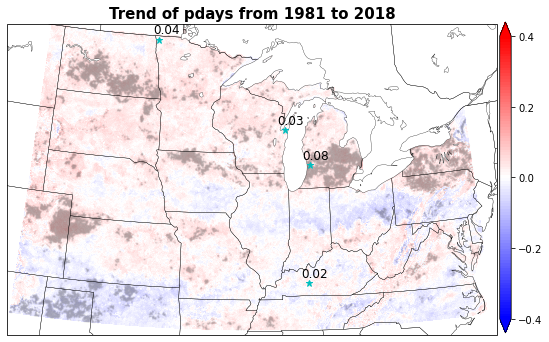

In [41]:
# slope = np.load('./GDD/var_yearly_slope.npy')
# pvalue = np.load('./GDD/var_yearly_pvalue.npy')
# name = ['FGREEN','BLOOM','YIELD','INJDAYS','POORDAYS']
slope = np.load('./GDD/var_yearly__slope_Cherry.npy')
pvalue = np.load('./GDD/var_yearly_pvalue_Cherry.npy')
name = ['fgreen','bloom','pdays','yield']
ii = 2
extent = [-105, -75, 34, 49]
loclat = [37.25, 42.87, 48.79, 44.58]
loclon = [-86.37, -86.04, -96.92, -87.71]
r = [.02, .08, .04, .03]
fig = plt.figure(figsize=(8, 6))
ax = plt.axes(projection=ccrs.AlbersEqualArea(np.mean(extent[:2]), np.mean(extent[2:])))
ax.set_extent(extent)
states = NaturalEarthFeature(category="cultural", scale="50m",
                             facecolor="none",
                             name="admin_1_states_provinces_shp")
ax.add_feature(states, linewidth=.3, edgecolor="black")
ax.add_feature(cartopy.feature.BORDERS, lw=.3, linestyle=':')
ax.add_feature(cartopy.feature.COASTLINE, lw=.3, linestyle=':')
ax.add_feature(cartopy.feature.LAKES, edgecolor='black', facecolor='white', lw=.3)

levels = MaxNLocator(nbins=100).tick_values(-.4, .4)
cmap = plt.get_cmap('bwr')
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

pc = plt.pcolormesh(Lon, Lat, slope[ii, :, :], cmap=cmap, norm=norm, transform=ccrs.PlateCarree())

plt.scatter(Lon, Lat, np.where(pvalue[ii, :, :]<0.05, 1, np.nan), 'grey', alpha=.1, transform=ccrs.PlateCarree())
for k in range(4):
    ax.plot(loclon[k], loclat[k], 'c*', markersize=7, transform=ccrs.PlateCarree())
    ax.text(loclon[k]-.5, loclat[k]+.3, f'{r[k]}', fontsize=12, transform=ccrs.PlateCarree())

plt.title(f'Trend of {name[ii]} from 1981 to 2018', fontsize=15, fontweight='bold')

fig.subplots_adjust(bottom=0, top=0.95, left=0.05, right=0.9)
cb_ax = fig.add_axes([0.905, 0.12, 0.02, 0.72])
cbar = fig.colorbar(pc, cax=cb_ax, ticks=[-.4, -.2, 0, .2, .4], extend='both')
plt.savefig(f'./plot/PRISM/cherry_{name[ii]}_trend_star.png')

Text(0.5, 1.0, 'Poor Days in WI')

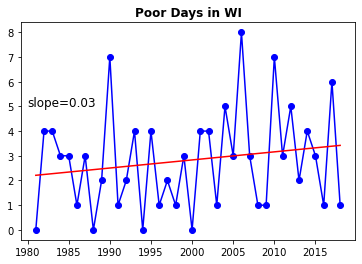

In [40]:
# df = pd.read_table(f'./GDD/output/yearly/44.83_-83.58_yearly.txt', delim_whitespace=True, 
#                                    names=('year','fgreen','bloom','yeild','INJDAYS','POORDAYS'))
# bloom = df.bloom.rolling(window=9, center=True).mean()
# mmask = ~np.isnan(bloom)
# r = stats.linregress(X[mmask], bloom[mmask])
df = pd.read_table(f'./GDD/cherry_WI_44.58_-87.71_yearly.txt', delim_whitespace=True, 
                                   names=('year','fgreen','bloom','pdays','yield'))
X = np.linspace(1981, 2018, 38)
r = stats.linregress(X, df.pdays)
plt.plot(X, df.pdays, 'bo-')
plt.plot(X, r.slope*X+r.intercept, 'r')
plt.text(1980, 5, f'slope={r.slope:.2f}', fontsize=12)
plt.title('Poor Days in WI', fontweight='bold')
# df.bloom[30]

<ipython-input-65-63b8a5d78b5b>:26: RuntimeWarning: invalid value encountered in less
  plt.scatter(Lon, Lat, np.where(pvalue[ii, :, :]<0.05, 1, np.nan), 'grey', alpha=.1, transform=ccrs.PlateCarree())


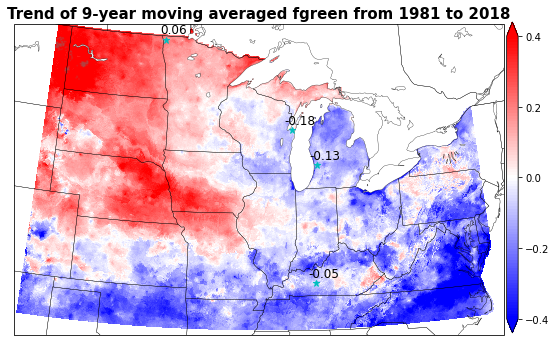

In [65]:
slope = np.load('./GDD/var_yearly_slope_RunningMeanwin9_Cherry.npy')
pvalue = np.load('./GDD/var_yearly_pvalue_RunningMeanwin9_Cherry.npy')
name = ['fgreen','bloom','pdays','yield']
ii = 0
extent = [-105, -75, 34, 49]
loclat = [37.25, 42.87, 48.79, 44.58]
loclon = [-86.37, -86.04, -96.92, -87.71]
r = [-.05, -.13, 0.06, -.18]
fig = plt.figure(figsize=(8, 6))
ax = plt.axes(projection=ccrs.AlbersEqualArea(np.mean(extent[:2]), np.mean(extent[2:])))
ax.set_extent(extent)
states = NaturalEarthFeature(category="cultural", scale="50m",
                             facecolor="none",
                             name="admin_1_states_provinces_shp")
ax.add_feature(states, linewidth=.3, edgecolor="black")
ax.add_feature(cartopy.feature.BORDERS, lw=.3, linestyle=':')
ax.add_feature(cartopy.feature.COASTLINE, lw=.3, linestyle=':')
ax.add_feature(cartopy.feature.LAKES, edgecolor='black', facecolor='white', lw=.3)

levels = MaxNLocator(nbins=100).tick_values(-.4, .4)
cmap = plt.get_cmap('bwr')
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

pc = plt.pcolormesh(Lon, Lat, slope[ii, :, :], cmap=cmap, norm=norm, transform=ccrs.PlateCarree())

plt.scatter(Lon, Lat, np.where(pvalue[ii, :, :]<0.05, 1, np.nan), 'grey', alpha=.1, transform=ccrs.PlateCarree())
for k in range(4):
    ax.plot(loclon[k], loclat[k], 'c*', markersize=7, transform=ccrs.PlateCarree())
    ax.text(loclon[k]-.5, loclat[k]+.3, f'{r[k]}', fontsize=12, transform=ccrs.PlateCarree())

plt.title(f'Trend of 9-year moving averaged {name[ii]} from 1981 to 2018', fontsize=15, fontweight='bold')

fig.subplots_adjust(bottom=0, top=0.95, left=0.05, right=0.9)
cb_ax = fig.add_axes([0.905, 0.12, 0.02, 0.72])
cbar = fig.colorbar(pc, cax=cb_ax, ticks=[-.4, -.2, 0, .2, .4], extend='both')
plt.savefig(f'./plot/PRISM/cherry_{name[ii]}_trend_star_RunningMeanwin9.png')

Text(0.5, 1.0, 'First Green Dates in WI (9-year Running mean)')

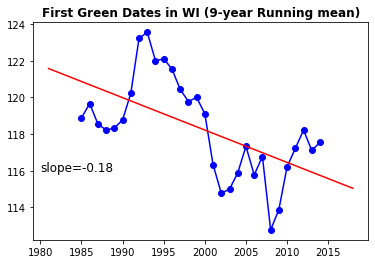

In [63]:
df = pd.read_table(f'./GDD/cherry_WI_44.58_-87.71_yearly.txt', delim_whitespace=True, 
                                   names=('year','fgreen','bloom','pdays','yield'))
fgreen = df.fgreen.rolling(window=9, center=True).mean()
X = np.linspace(1981, 2018, 38)
mask = ~np.isnan(fgreen)
r = stats.linregress(X[mask], fgreen[mask])
plt.plot(X, fgreen, 'bo-')
plt.plot(X, r.slope*X+r.intercept, 'r')
plt.text(1980, 116, f'slope={r.slope:.2f}', fontsize=12)
plt.title('First Green Dates in WI (9-year Running mean)', fontweight='bold')

In [7]:
# df = pd.read_table(f'./GDD/output/yearly/44.00_-82.83_yearly.txt', delim_whitespace=True, 
#                                    names=('year','fgreen','bloom','yeild','INJDAYS','POORDAYS'))
# bloom = df.bloom.rolling(window=9, center=True).mean()
# X = np.linspace(1981, 2018, 38)
# mask = ~np.isnan(bloom)
# r = stats.linregress(X[mask], bloom[mask])
# plt.plot(X, bloom, 'bo-')
# plt.plot(X, r.slope*X+r.intercept, 'r')
# plt.text(1980, 145, f'slope={r.slope:.2f}', fontsize=12)
# r.slope

In [8]:
# df = pd.read_table(f'./GDD/output/yearly/46.42_-87.83_yearly.txt', delim_whitespace=True, 
#                                    names=('year','fgreen','bloom','yeild','INJDAYS','POORDAYS'))
# bloom = df.bloom.rolling(window=9, center=True).mean()
# X = np.linspace(1981, 2018, 38)
# mask = ~np.isnan(bloom)
# r = stats.linregress(X[mask], bloom[mask])
# plt.plot(X, bloom, 'bo-')
# plt.plot(X, r.slope*X+r.intercept, 'r')
# plt.text(1980, 152, f'slope={r.slope:.2f}', fontsize=12)
# r.slope

In [9]:
# df = pd.read_table(f'./GDD/output/yearly/42.71_-83.92_yearly.txt', delim_whitespace=True, 
#                                    names=('year','fgreen','bloom','yeild','INJDAYS','POORDAYS'))
# bloom = df.bloom.rolling(window=9, center=True).mean()
# X = np.linspace(1981, 2018, 38)
# mask = ~np.isnan(bloom)
# r = stats.linregress(X[mask], bloom[mask])
# plt.plot(X, bloom, 'bo-')
# plt.plot(X, r.slope*X+r.intercept, 'r')
# plt.text(1980, 133, f'slope={r.slope:.2f}', fontsize=12)
# r.slope

In [24]:
slope = np.load('./GDD/var_yearly_slope.npy')
pvalue = np.load('./GDD/var_yearly_pvalue.npy')
name = ['FGREEN','BLOOM','YIELD','INJDAYS','POORDAYS']
ii = 0
extent = [-105, -75, 34, 49]
loclat = [45.62, 44.50, 44.00, 46.42, 42.71]
loclon = [-84.71, -87.71, -82.83, -87.83, -83.92]
r = [-0.04, 0.02, 0.11, -0.08, 0.09]

fig = plt.figure(figsize=(8, 6))
ax = plt.axes(projection=ccrs.AlbersEqualArea(np.mean(extent[:2]), np.mean(extent[2:])))
ax.set_extent(extent)
states = NaturalEarthFeature(category="cultural", scale="50m",
                             facecolor="none",
                             name="admin_1_states_provinces_shp")
ax.add_feature(states, linewidth=.3, edgecolor="black")
ax.add_feature(cartopy.feature.BORDERS, lw=.3, linestyle=':')
ax.add_feature(cartopy.feature.COASTLINE, lw=.3, linestyle=':')
ax.add_feature(cartopy.feature.LAKES, edgecolor='black', facecolor='white', lw=.3)

levels = MaxNLocator(nbins=100).tick_values(-.4, .4)
cmap = plt.get_cmap('bwr')
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

pc = plt.pcolormesh(Lon, Lat, slope[ii, :, :], cmap=cmap, norm=norm, transform=ccrs.PlateCarree())

plt.scatter(Lon, Lat, np.where(pvalue[ii, :, :]<0.05, 1, np.nan), 'grey', alpha=.1, transform=ccrs.PlateCarree())
for k in range(5):
    ax.plot(loclon[k], loclat[k], 'c*', markersize=7, transform=ccrs.PlateCarree())
#     ax.text(loclon[k]-1, loclat[k]+1, f'({loclon[k]}, {loclat[k]})', transform=ccrs.PlateCarree())
    ax.text(loclon[k]-.5, loclat[k]+.3, f'{r[k]}', transform=ccrs.PlateCarree())

plt.title(f'Trend of {name[ii]} from 1981 to 2018', fontsize=15, fontweight='bold')

fig.subplots_adjust(bottom=0, top=0.95, left=0.05, right=0.9)
cb_ax = fig.add_axes([0.905, 0.12, 0.02, 0.72])
cbar = fig.colorbar(pc, cax=cb_ax, ticks=[-.4, -.2, 0, .2, .4], extend='both')
plt.savefig(f'./plot/PRISM/{name[ii]}_trend_star.png')

In [25]:
slope = np.load('./GDD/var_yearly_slope_RunningMeanwin9.npy')
pvalue = np.load('./GDD/var_yearly_pvalue_RunningMeanwin9.npy')
name = ['FGREEN','BLOOM','YIELD','INJDAYS','POORDAYS']
ii = 0
extent = [-105, -75, 34, 49]
loclat = [45.62, 44.50, 44.00, 46.42, 42.71]
loclon = [-84.71, -87.71, -82.83, -87.83, -83.92]
r = [-0.17, -0.07, 0.08, -0.19, 0.05]

fig = plt.figure(figsize=(8, 6))
ax = plt.axes(projection=ccrs.AlbersEqualArea(np.mean(extent[:2]), np.mean(extent[2:])))
ax.set_extent(extent)
states = NaturalEarthFeature(category="cultural", scale="50m",
                             facecolor="none",
                             name="admin_1_states_provinces_shp")
ax.add_feature(states, linewidth=.3, edgecolor="black")
ax.add_feature(cartopy.feature.BORDERS, lw=.3, linestyle=':')
ax.add_feature(cartopy.feature.COASTLINE, lw=.3, linestyle=':')
ax.add_feature(cartopy.feature.LAKES, edgecolor='black', facecolor='white', lw=.3)

levels = MaxNLocator(nbins=100).tick_values(-.4, .4)
cmap = plt.get_cmap('bwr')
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

pc = plt.pcolormesh(Lon, Lat, slope[ii, :, :], cmap=cmap, norm=norm, transform=ccrs.PlateCarree())

plt.scatter(Lon, Lat, np.where(pvalue[ii, :, :]<0.05, 1, np.nan), 'grey', alpha=.1, transform=ccrs.PlateCarree())
for k in range(5):
    ax.plot(loclon[k], loclat[k], 'c*', markersize=7, transform=ccrs.PlateCarree())
#     ax.text(loclon[k]-1, loclat[k]+1, f'({loclon[k]}, {loclat[k]})', transform=ccrs.PlateCarree())
    ax.text(loclon[k]-.5, loclat[k]+.3, f'{r[k]}', transform=ccrs.PlateCarree())

plt.title(f'Trend of 9-year monving averaged {name[ii]} from 1981 to 2018', fontsize=15, fontweight='bold')

fig.subplots_adjust(bottom=0, top=0.95, left=0.05, right=0.9)
cb_ax = fig.add_axes([0.905, 0.12, 0.02, 0.72])
cbar = fig.colorbar(pc, cax=cb_ax, ticks=[-.4, -.2, 0, .2, .4], extend='both')
plt.savefig(f'./plot/PRISM/{name[ii]}_trend_star_RunningMeanwin9.png')

-0.17295760721789638

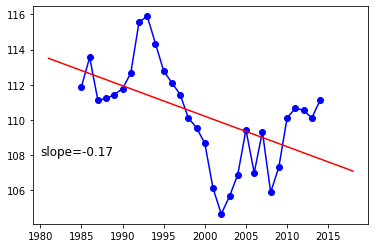

In [14]:
df = pd.read_table(f'./GDD/output/yearly/45.62_-84.71_yearly.txt', delim_whitespace=True, 
                                   names=('year','fgreen','bloom','yeild','INJDAYS','POORDAYS'))
X = np.linspace(1981, 2018, 38)
fgreen = df.fgreen.rolling(window=9, center=True).mean()
mmask = ~np.isnan(fgreen)
r = stats.linregress(X[mmask], fgreen[mmask])
plt.plot(X, fgreen, 'bo-')
plt.plot(X, r.slope*X+r.intercept, 'r')
plt.text(1980, 108, f'slope={r.slope:.2f}', fontsize=12)
r.slope

-0.06622172784575445

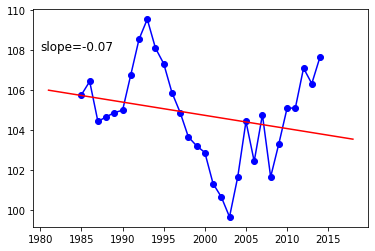

In [15]:
df = pd.read_table(f'./GDD/output/yearly/44.50_-87.71_yearly.txt', delim_whitespace=True, 
                                   names=('year','fgreen','bloom','yeild','INJDAYS','POORDAYS'))
X = np.linspace(1981, 2018, 38)
fgreen = df.fgreen.rolling(window=9, center=True).mean()
mmask = ~np.isnan(fgreen)
r = stats.linregress(X[mmask], fgreen[mmask])
plt.plot(X, fgreen, 'bo-')
plt.plot(X, r.slope*X+r.intercept, 'r')
plt.text(1980, 108, f'slope={r.slope:.2f}', fontsize=12)
r.slope
# df.fgreen[30]

0.08300580892349509

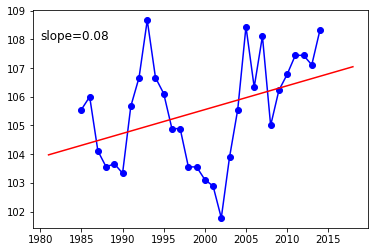

In [17]:
df = pd.read_table(f'./GDD/output/yearly/44.00_-82.83_yearly.txt', delim_whitespace=True, 
                                   names=('year','fgreen','bloom','yeild','INJDAYS','POORDAYS'))
X = np.linspace(1981, 2018, 38)
fgreen = df.fgreen.rolling(window=9, center=True).mean()
mmask = ~np.isnan(fgreen)
r = stats.linregress(X[mmask], fgreen[mmask])
plt.plot(X, fgreen, 'bo-')
plt.plot(X, r.slope*X+r.intercept, 'r')
plt.text(1980, 108, f'slope={r.slope:.2f}', fontsize=12)
r.slope
# df.fgreen[30]

129

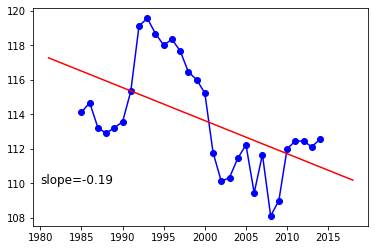

In [19]:
df = pd.read_table(f'./GDD/output/yearly/46.42_-87.83_yearly.txt', delim_whitespace=True, 
                                   names=('year','fgreen','bloom','yeild','INJDAYS','POORDAYS'))
X = np.linspace(1981, 2018, 38)
fgreen = df.fgreen.rolling(window=9, center=True).mean()
mmask = ~np.isnan(fgreen)
r = stats.linregress(X[mmask], fgreen[mmask])
plt.plot(X, fgreen, 'bo-')
plt.plot(X, r.slope*X+r.intercept, 'r')
plt.text(1980, 110, f'slope={r.slope:.2f}', fontsize=12)
r.slope
df.fgreen[30]

0.05279940674823883

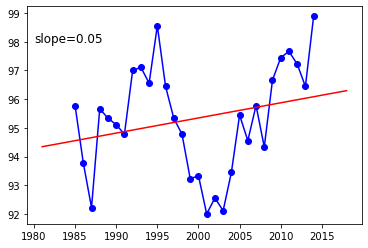

In [21]:
df = pd.read_table(f'./GDD/output/yearly/42.71_-83.92_yearly.txt', delim_whitespace=True, 
                                   names=('year','fgreen','bloom','yeild','INJDAYS','POORDAYS'))
X = np.linspace(1981, 2018, 38)
fgreen = df.fgreen.rolling(window=9, center=True).mean()
mmask = ~np.isnan(fgreen)
r = stats.linregress(X[mmask], fgreen[mmask])
plt.plot(X, fgreen, 'bo-')
plt.plot(X, r.slope*X+r.intercept, 'r')
plt.text(1980, 98, f'slope={r.slope:.2f}', fontsize=12)
r.slope

<font size=4 color=blue>Theil-Sen Slope and Mann-Kendall test

In [8]:
import pymannkendall as mk

df = pd.read_table(f'./GDD/output/yearly/44.00_-82.83_yearly.txt', delim_whitespace=True, 
                                   names=('year','fgreen','bloom','yeild','INJDAYS','POORDAYS'))
r = mk.original_test(df.bloom)
# plt.plot(X, df.bloom, 'bo-')
# plt.plot(X, r.slope*X+r.intercept, 'r')
# plt.text(1990, 160, f'slope={r.slope:.2f}', fontsize=12)
r, r.p

(Mann_Kendall_Test(trend='no trend', h=False, p=0.19435078805135264, z=1.2978153662249048, Tau=0.14793741109530584, s=104.0, var_s=6298.666666666667, slope=0.14814814814814814, intercept=139.75925925925927),
 0.19435078805135264)

In [8]:
# a = pd.DataFrame([1, 2, 3, 4, 5, 6, 7, 8, 9])
# a.rolling(window=5, center=True).mean()